# Energy Price Prediction with ARIMA & SARIMA

In [85]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


from scipy import stats
import statsmodels.api as sm
from itertools import product

import plotly.graph_objects as go
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

sns.set(rc={"axes.facecolor":"Beige" , "axes.grid" : False})

In [13]:
df = pd.read_csv(r"D:\UNH Materials\Projects\Energy Price Predictions\European Energy Market\data\EU_energy_data.csv")
df.head()

,Unnamed: 0,fecha,hora,sistema,bandera,precio,tipo_moneda,origen_dato,fecha_actualizacion
0,0,2010-07-21,1,HU,1,39.287,1,6,2021-10-01 12:39:53
1,1,2010-07-21,2,HU,1,35.925,1,6,2021-10-01 12:39:53
2,2,2010-07-21,3,HU,1,33.223,1,6,2021-10-01 12:39:53
3,3,2010-07-21,4,HU,1,30.842,1,6,2021-10-01 12:39:53
4,4,2010-07-21,5,HU,1,33.395,1,6,2021-10-01 12:39:53


In [21]:
df.shape

(1831555, 7)

In [14]:
# Rename Columns
df = df.rename(columns = {'fecha' : 'Date',
                          'hora' : 'Hour' , 
                          'sistema' : 'EU_countries',
                          'bandera' : 'Renewable/Non_Renewable',
                          'precio' : 'Cost(€/MWh)',
                          'tipo_moneda' : 'CurrencyType',
                          'origen_dato' : 'DataSource', 
                          'fecha_actualizacion' : 'Updated_Date'}
                )                                                
df = df.drop('Unnamed: 0',axis=1)

In [15]:
df.head()

,Date,Hour,EU_countries,Renewable/Non_Renewable,Cost(€/MWh),CurrencyType,DataSource,Updated_Date
0,2010-07-21,1,HU,1,39.287,1,6,2021-10-01 12:39:53
1,2010-07-21,2,HU,1,35.925,1,6,2021-10-01 12:39:53
2,2010-07-21,3,HU,1,33.223,1,6,2021-10-01 12:39:53
3,2010-07-21,4,HU,1,30.842,1,6,2021-10-01 12:39:53
4,2010-07-21,5,HU,1,33.395,1,6,2021-10-01 12:39:53


In [16]:
# Merge Date and Hour columns
df['Hour'] = df['Hour'].astype(str).str.zfill(2)
try:
    df['Hour'] = pd.to_numeric(df['Hour'])
except:
    # Handle conversion errors (e.g., non-numeric characters)
    print("Error converting 'Hour' column to numeric")

# Function to convert the range
def convert_range(value):
    # Handle edge cases (leading zero and exceeding 24)
    if value == '01':
        return 0
    elif value > 24:
        raise ValueError("Value exceeds 24")
    else:
        # Remove leading zero (assuming strings) or subtract 1 (assuming integers)
        return int(value) - 1 if isinstance(value, int) else int(value[1:])

# Function to replace values with leading zeros (handles all cases)
def replace_with_leading_zero(value):
    if 0 <= value <= 23:
        return f"{value:02d}"  # Use f-string for consistent formatting
    else:
        raise ValueError(f"Value {value} is outside the range 0-12")

In [17]:
# Apply the function
df['Hour'] = df['Hour'].apply(convert_range)
df['Hour'] = df['Hour'].apply(replace_with_leading_zero)
df['Hour'] = df['Hour'].astype(str)  # Ensure Hour is string type
df['Hour'] = df['Hour'] + ':00:00'

df["Period"] = df[["Date","Hour"]].apply(" ".join, axis=1)

# Filter useful columns
df = df [['Period','EU_countries', 'Renewable/Non_Renewable',
       'Cost(€/MWh)', 'CurrencyType', 'DataSource', 'Updated_Date']]

df['Period'] = pd.to_datetime(df['Period'],format ="%Y-%m-%d %H:%M:%S" )
df.head()

,Period,EU_countries,Renewable/Non_Renewable,Cost(€/MWh),CurrencyType,DataSource,Updated_Date
0,2010-07-21 00:00:00,HU,1,39.287,1,6,2021-10-01 12:39:53
1,2010-07-21 01:00:00,HU,1,35.925,1,6,2021-10-01 12:39:53
2,2010-07-21 02:00:00,HU,1,33.223,1,6,2021-10-01 12:39:53
3,2010-07-21 03:00:00,HU,1,30.842,1,6,2021-10-01 12:39:53
4,2010-07-21 04:00:00,HU,1,33.395,1,6,2021-10-01 12:39:53


In [24]:
# Let's Analyse a Specific Country = France
df_France = df[df['EU_countries']== "FR"]

# Remove the unnecessary feature
df_France = df_France.drop(['EU_countries','CurrencyType','DataSource','Updated_Date','Renewable/Non_Renewable'],axis=1)
df_France.head().style.set_properties(subset=['Period'], **{'background-color': 'yellow'})

,Period,Cost(€/MWh)
179166,2014-01-01 00:00:00,15.150000
179187,2014-01-01 01:00:00,12.960000
179208,2014-01-01 02:00:00,12.090000
179229,2014-01-01 03:00:00,11.700000
179250,2014-01-01 04:00:00,11.660000


In [25]:
# Creating a copy to keep original Dataset intact
France_df = df_France.copy('Deep')

In [26]:
df_France = df_France.set_index('Period')
df_France.sort_index(inplace=True)
df_France.head()

,Cost(€/MWh)
Period,
2014-01-01 00:00:00,15.15
2014-01-01 01:00:00,12.96
2014-01-01 02:00:00,12.09
2014-01-01 03:00:00,11.70
2014-01-01 04:00:00,11.66


# Exploratory Data Analysis and Visualization

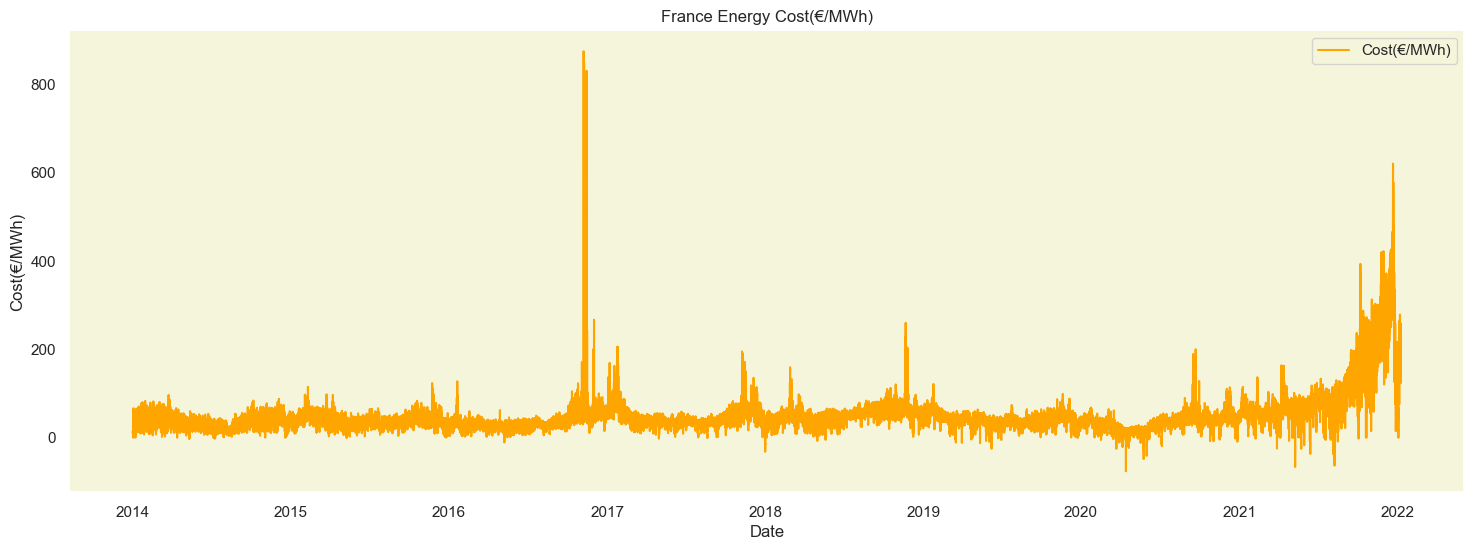

In [61]:
# Energy Cost over the period
plt.figure(figsize = (18,6))
plt.plot(df_France.index,df_France['Cost(€/MWh)'],label= 'Cost(€/MWh)',color = 'orange')
plt.title('France Energy Cost(€/MWh)')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.grid(False)
plt.legend()
plt.show()

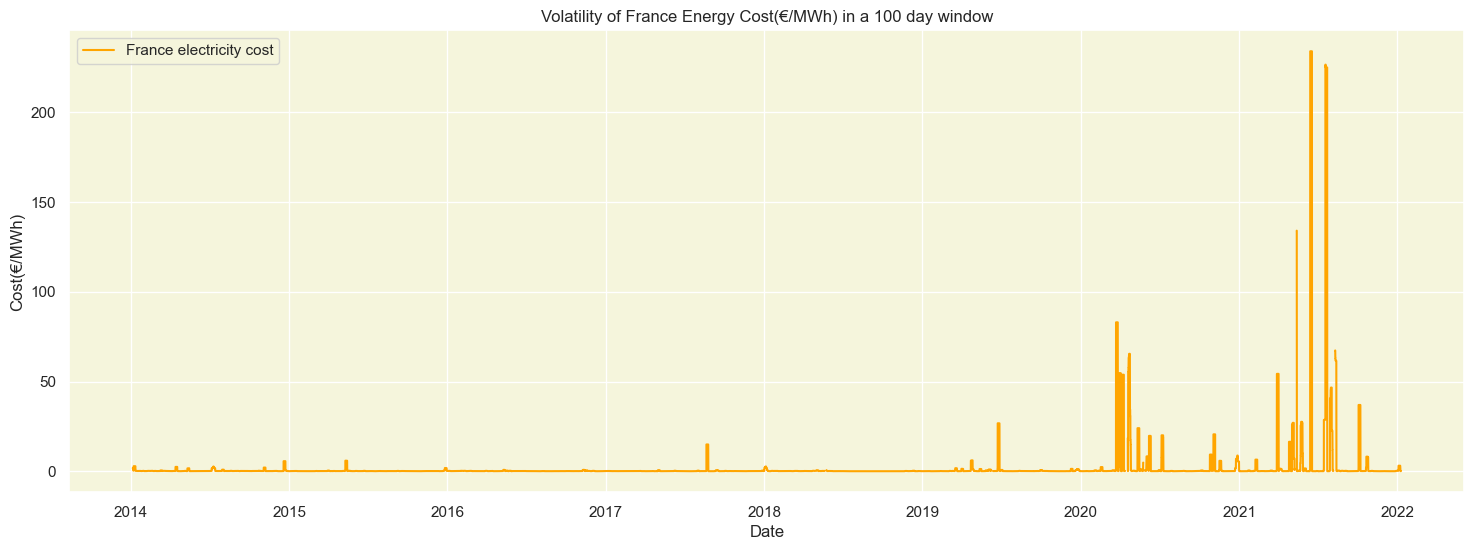

In [68]:
# Percent Change over a 100 time period window
df_France['Change'] = df_France['Cost(€/MWh)'].pct_change()
window_size = 100
df_100 = df_France['Change'].rolling(window = window_size).std()

#plotting
plt.figure(figsize = (18,6))
plt.plot(df_France.index , df_100 , label = 'France electricity cost' , color = 'orange')
plt.title('Volatility of France Energy Cost(€/MWh) in a 100 day window')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

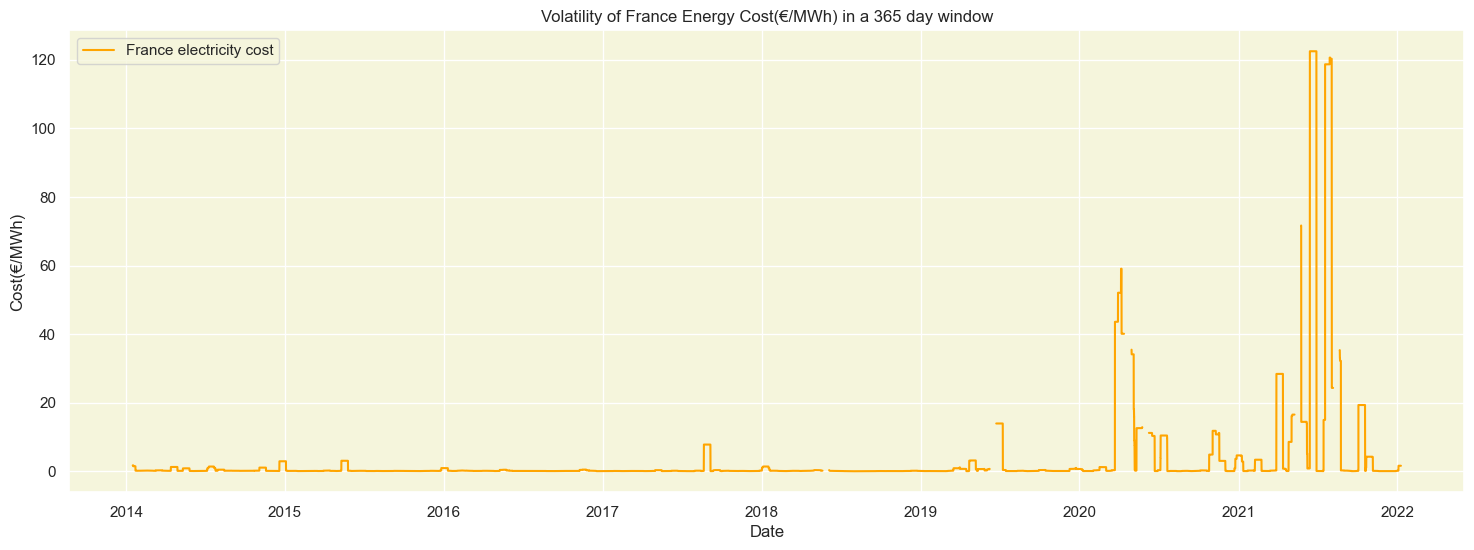

In [69]:
# Percent Change over a 365 day (Year) time period window
df_France['Change'] = df_France['Cost(€/MWh)'].pct_change()
window_size = 365
df_365 = df_France['Change'].rolling(window = window_size).std()

#plotting
plt.figure(figsize = (18,6))
plt.plot(df_France.index , df_365 , label = 'France electricity cost' , color = 'orange')
plt.title('Volatility of France Energy Cost(€/MWh) in a 365 day window')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Moving Average and Exponential Moving Average Over a period of 30 days
df_France['MA'] = df_France['Cost(€/MWh)'].rolling(window = 30).mean()
df_France['EMA'] = df_France['Cost(€/MWh)'].ewm(span = 30 , adjust = False).mean()

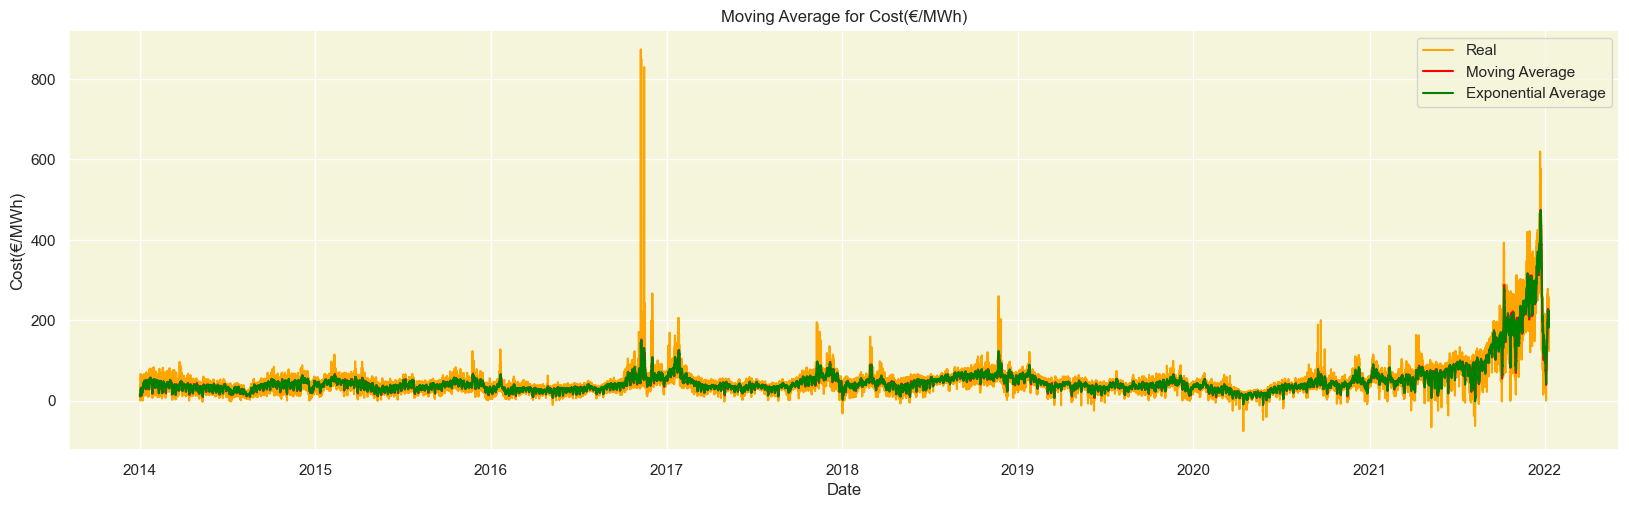

In [80]:
plt.figure(figsize = (20,12))

plt.subplot(2,1,1)
plt.plot(df_France.index,df_France['Cost(€/MWh)'], label = 'Real', color='orange')
plt.plot(df_France.index,df_France['MA'] , label = 'Moving Average' , color = 'red')
plt.plot(df_France.index,df_France['EMA'] , label = 'Exponential Average' , color = 'green')
plt.title('Moving Average for Cost(€/MWh)')
plt.xlabel('Date')
plt.ylabel('Cost(€/MWh)')
plt.legend()
plt.grid()

In [81]:
# Now we will use France_df which we created earlier
France_df = France_df.set_index('Period')
France_df.head()

,Cost(€/MWh)
Period,
2014-01-01 00:00:00,15.15
2014-01-01 01:00:00,12.96
2014-01-01 02:00:00,12.09
2014-01-01 03:00:00,11.70
2014-01-01 04:00:00,11.66


# Augmented Dickey-Fuller (ADF) test to check Stationarity in Time Series data

In [84]:
result = adfuller(France_df['Cost(€/MWh)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print("\n")
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -7.237777
p-value: 0.000000


Critial Values:
   1%, -3.430443076272825
Critial Values:
   5%, -2.8615811380624825
Critial Values:
   10%, -2.5667918963845726


The p-value is less than 0.05, hence we can reject the null hypothesis and take that the series is stationary.

# Auto Correlation Plot

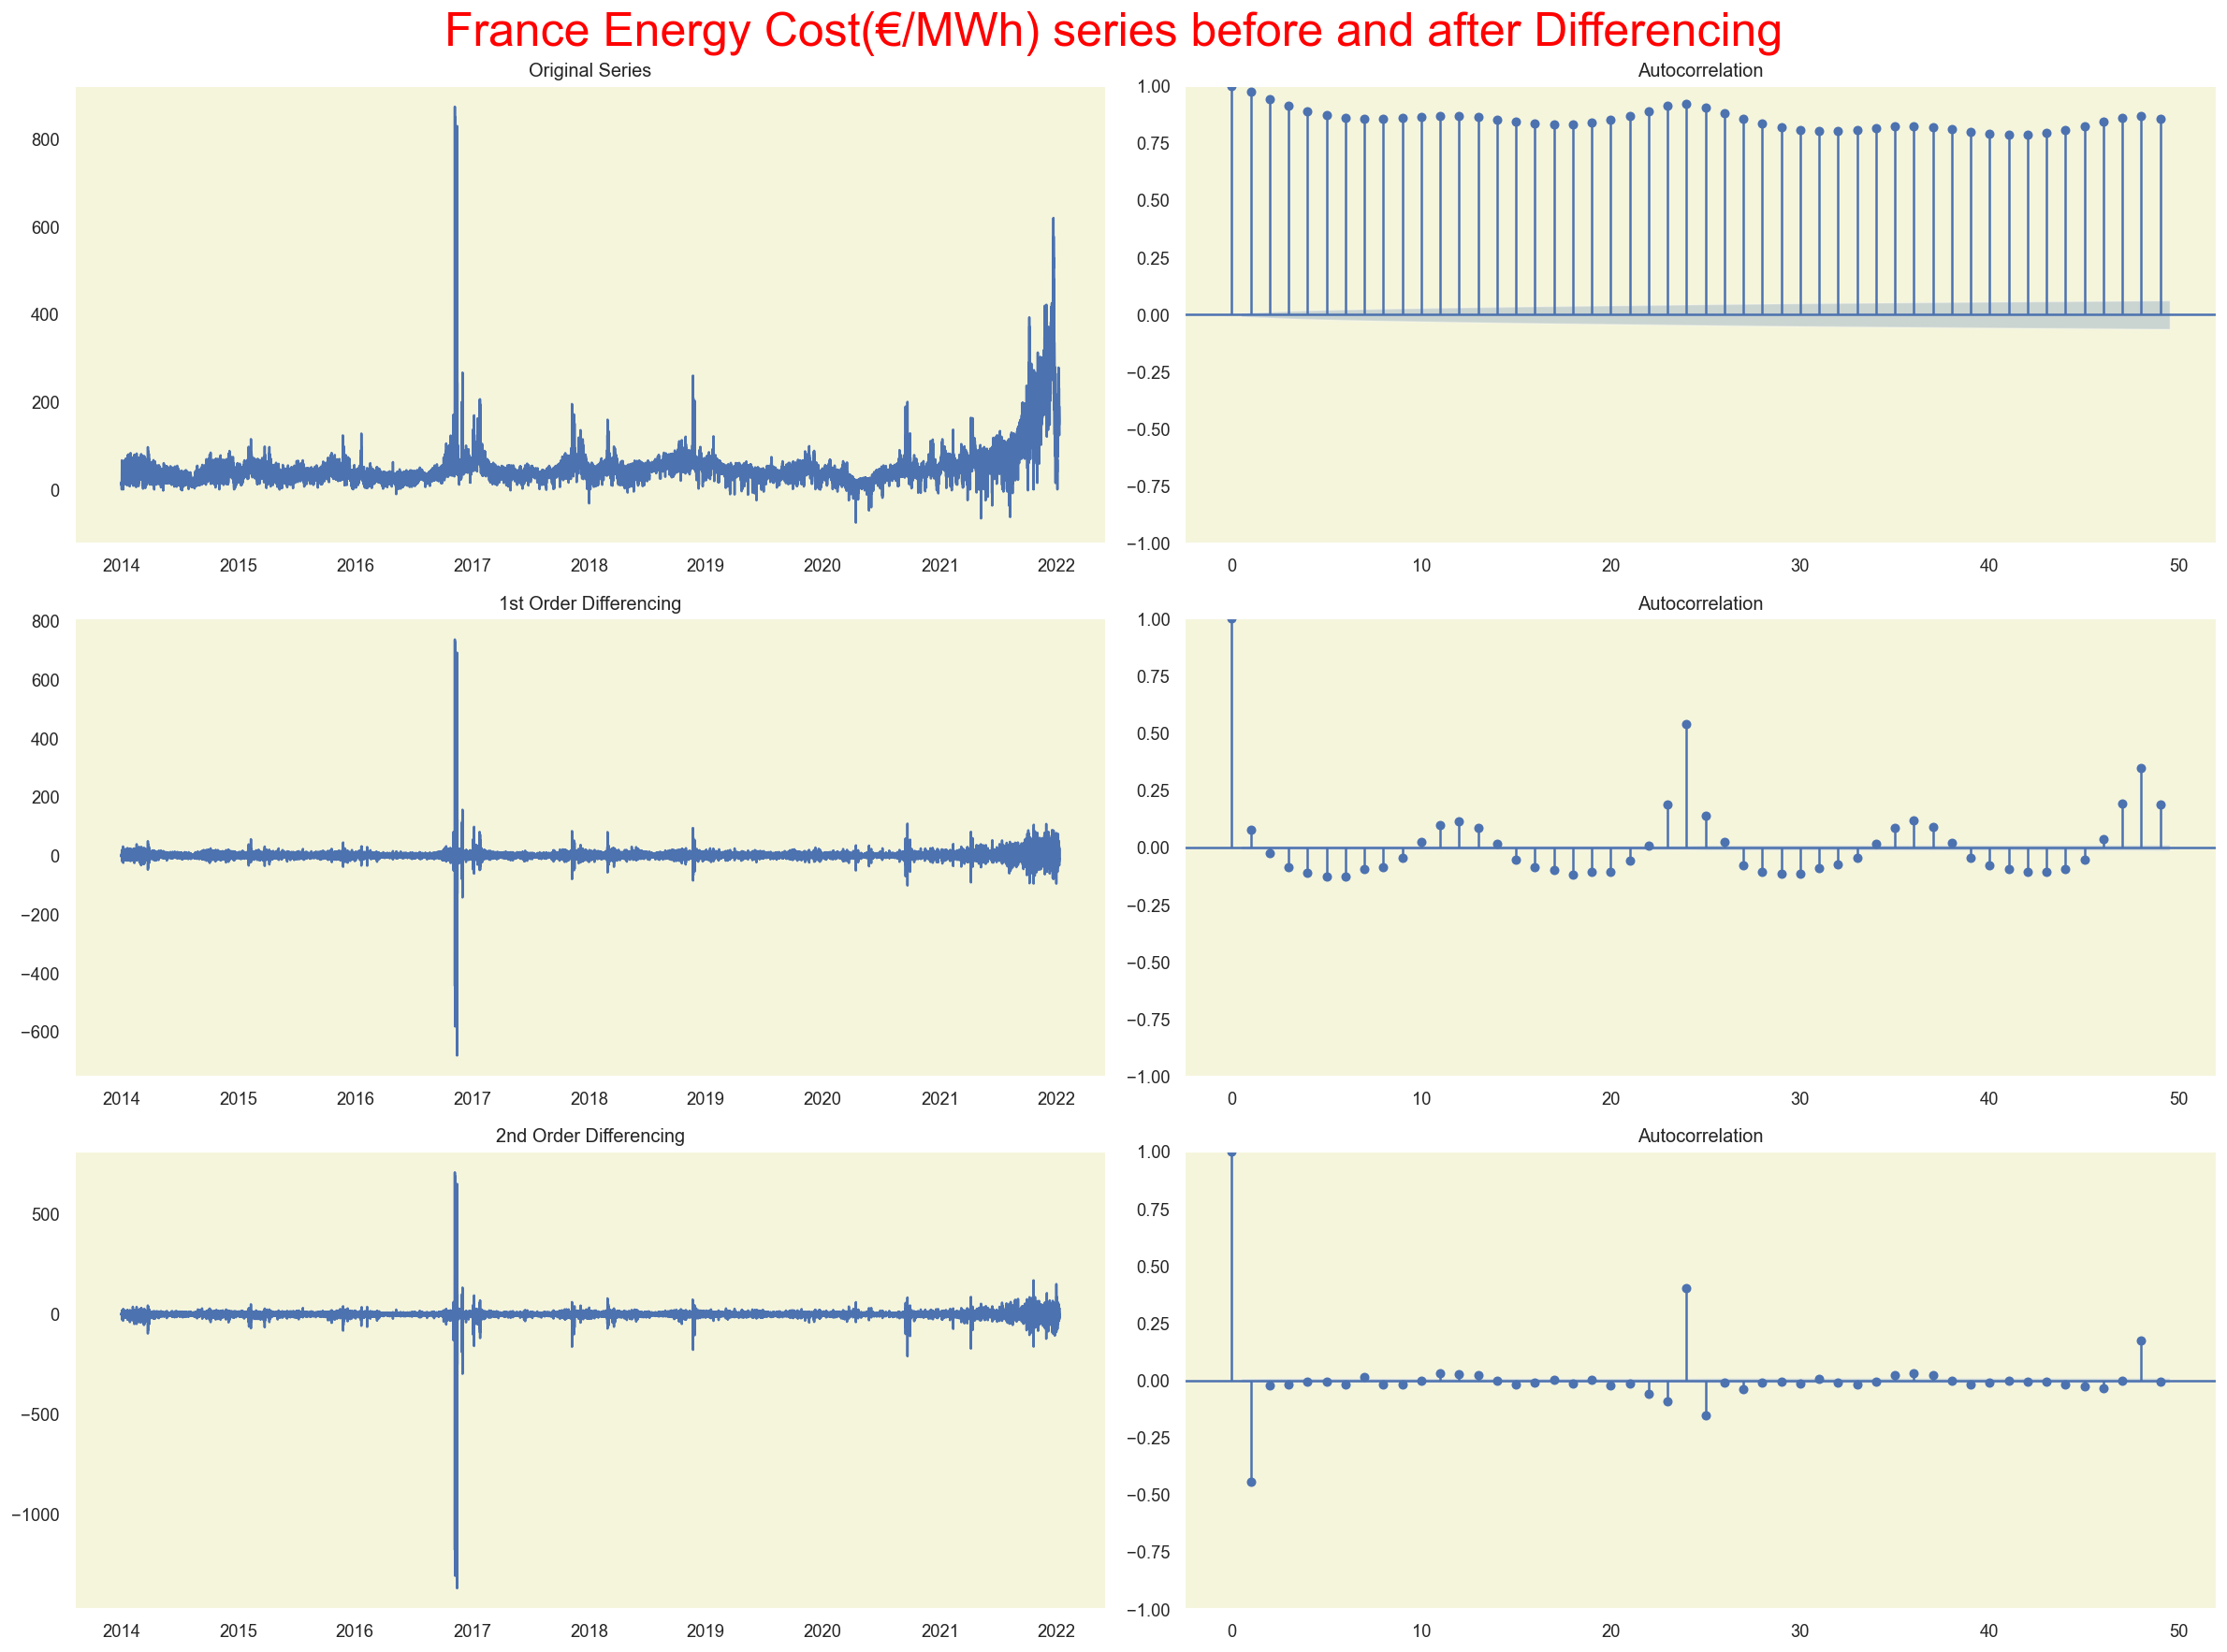

In [91]:
plt.rcParams.update({'figure.figsize':(20,15), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(France_df['Cost(€/MWh)'])
axes[0, 0].set_title('Original Series')

# Plotting the ACF
plot_acf(France_df['Cost(€/MWh)'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(France_df['Cost(€/MWh)'].diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(France_df['Cost(€/MWh)'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(France_df['Cost(€/MWh)'].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(France_df['Cost(€/MWh)'].diff().diff().dropna(), ax=axes[2, 1])

plt.suptitle('France Energy Cost(€/MWh) series before and after Differencing', size = 30,color= 'Red')
plt.tight_layout()

# fig.subplots_adjust(hspace=0.4)

plt.show()